# **X-ray spectral analysis using Gammapy**

This notebook explains how to perform a simple X-ray spectral analysis using a code based on `Gammapy 0.20`. In this example we jointly model 3 data sets (one for each of the instruments onboard of the XMM satellite) using an absorbed powerlaw function.

Note that this notebook can easily be adapted to jointly fit multiwavelength data from other instruments, as explained in the corresponding tutorials on the Gammapy webpage.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel
from gammapy.datasets import Datasets

In [4]:
from gammapyXray import *

In [5]:
from sherpa.astro.xspec import XSwabs
from sherpa.models import PowLaw1D

# Load and inspect the X-ray data sets

In [6]:
filename = "XMM_test_files/PN_PWN.grp"
pn_dataset = StandardOGIPDataset.read(filename)
filename = "XMM_test_files/MOS1_PWN.grp"
mos1_dataset = StandardOGIPDataset.read(filename)
filename = "XMM_test_files/MOS2_PWN.grp"
mos2_dataset = StandardOGIPDataset.read(filename)

/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(1.0, 10.0)

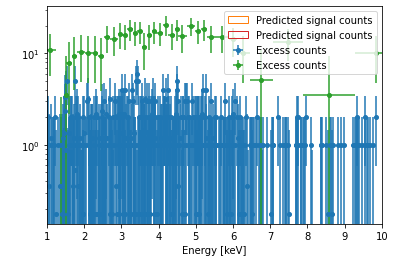

In [7]:
ax = pn_dataset.plot_excess()
ax = pn_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

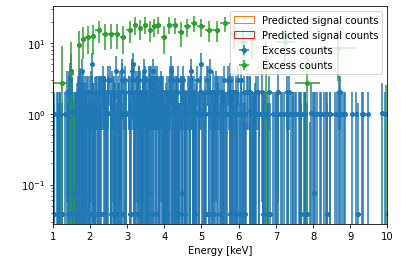

In [8]:
ax = mos1_dataset.plot_excess()
ax = mos1_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

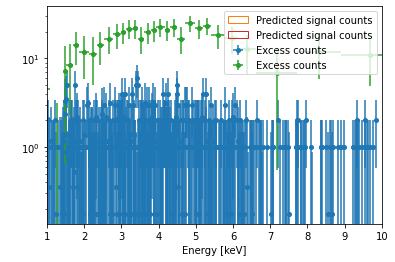

In [9]:
ax = mos2_dataset.plot_excess()
ax = mos2_dataset.grouped.plot_excess()
plt.xlim(1,10)

Create a joint datasets:

In [10]:
xmm_datasets = Datasets(datasets=[pn_dataset, mos1_dataset, mos2_dataset])

# Modeling

The `~gammapyX.SherpaSpectralModel` is a wrapper that can be used for fitting `Sherpa` and `XSpec` models within the `Gammapy` framework.

Let's verify that it yields the same results as the plain `Sherpa` and `XSpec` models (assuming for example a `wabs`*`powerlaw` model):


**************************************************************
The wabs model is obsolete and is only included for comparison
with historical results. The tbabs model should be used for
the ISM or phabs for general photoelectric absorption.
**************************************************************


/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


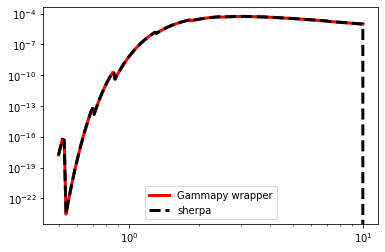

In [11]:
fig, ax = plt.subplots()
energy_grid = np.linspace(0.5, 10.0, 1000) * u.keV

plaw = PowLaw1D()
plaw.ampl=1e-3
plaw.gamma=2

abs_model = XSwabs()
abs_model.nH = 5

# Gammapy wrapper
f1 = SherpaSpectralModel(plaw) 
f2 = SherpaSpectralModel(abs_model, default_units=(u.keV, 1))
f3 = f1 * f2
ax.loglog(energy_grid, f3(energy_grid), color="r", lw=3, label="Gammapy wrapper")

#Plain sherpa
plaw_with_abs = plaw * abs_model

ax.loglog(energy_grid.value, plaw_with_abs(energy_grid.value), color="k", ls="--", lw=3, label="sherpa")

plt.legend()

Assign the model to the joint data set:

In [12]:
model = SkyModel(spectral_model=f3)
xmm_datasets.models=[model]

/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


Define min/max values for the free model parameters and inspect the parameters table:

In [13]:
xmm_datasets.models[0].spectral_model.model1.ampl.min = 0
xmm_datasets.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str5,float64,str1,int64,float64,float64,bool,bool,str1
spectral,gamma,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,ref,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,ampl,1.0000e-03,,0.000e+00,0.000e+00,nan,False,True,
spectral,nH,5.0000e+00,,0.000e+00,nan,nan,False,False,


Restrict the fit range for each instrument:

In [14]:
pn_dataset.mask_fit = pn_dataset._geom.energy_mask(1.5*u.keV, 10*u.keV)
mos1_dataset.mask_fit = mos1_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)
mos2_dataset.mask_fit = mos2_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)

Run the binned joint-likelihood fit:

In [15]:
%%time
fit = Fit()
fit_result = fit.run(xmm_datasets)

/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)
/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


CPU times: user 41 s, sys: 27.6 ms, total: 41.1 s
Wall time: 41.2 s


Inspect the fit output:

In [16]:
print(fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 132
	total stat : 70.27

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [17]:
print(fit_result.parameters.to_table())

  type    name   value    unit   error      min    max frozen is_norm link
-------- ----- ---------- ---- --------- --------- --- ------ ------- ----
spectral gamma 1.8533e+00      2.710e-01       nan nan  False   False     
spectral   ref 1.0000e+00      0.000e+00       nan nan   True   False     
spectral  ampl 5.7192e-04      2.655e-04 0.000e+00 nan  False    True     
spectral    nH 6.1008e+00      1.013e+00       nan nan  False   False     


(<AxesSubplot:xlabel='Energy [keV]', ylabel='$\\mathrm{}$'>,
 <AxesSubplot:xlabel='Energy [keV]', ylabel='Residuals\ndata - model'>)

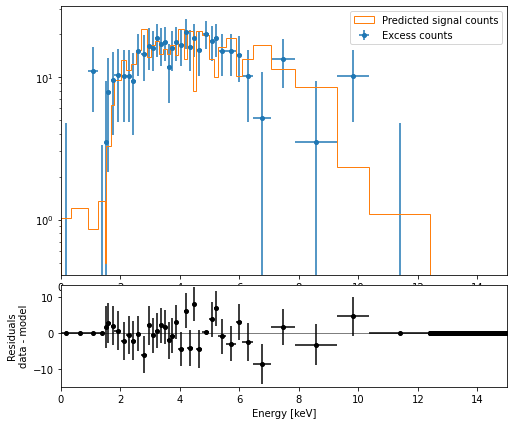

In [18]:
pn_dataset.plot_fit()

<AxesSubplot:xlabel='Energy [keV]', ylabel='Residuals (data - model)'>

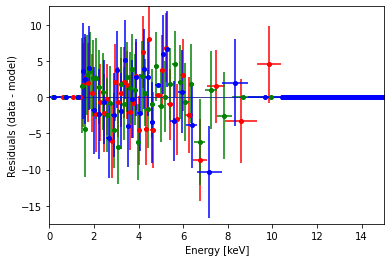

In [19]:
pn_dataset.plot_residuals_spectral(color="r")
mos1_dataset.plot_residuals_spectral(color="g")
mos2_dataset.plot_residuals_spectral(color="b")

# Comparison with reference results obtained with plain sherpa

in this section we provide a comparison between the fit results obtained in this notebook, using `Gammapy`, and the results obtained with a standard `Sherpa` fitting with the same assumptions.

The reference `Sherpa` notebook can be found at: https://github.com/luca-giunti/share/blob/master/CIAO_sherpa_validation_nb.ipynb

In [20]:
# Fit results obtained with Sherpa
amplitude_sherpa = (0.000569626, 0.000251357)
index_sherpa = (1.85112, 0.261476)
nh_sherpa = (6.11597, 0.904329)

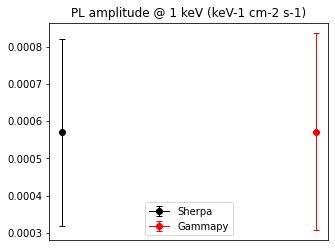

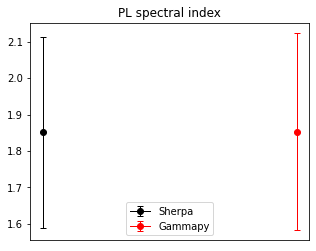

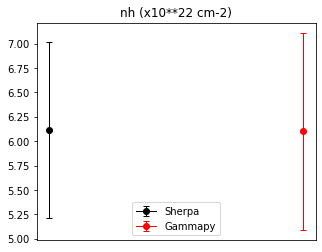

In [21]:
opts = {"marker": "o", "lw": 1, "capsize": 3}
pars_sherpa = [amplitude_sherpa, index_sherpa, nh_sherpa]
pars_gammapy = [fit_result.parameters["ampl"], fit_result.parameters["gamma"], fit_result.parameters["nH"]]
titles = ["PL amplitude @ 1 keV (keV-1 cm-2 s-1)", "PL spectral index", "nh (x10**22 cm-2)"]

for par_sherpa, par_gammapy, title in zip(pars_sherpa, pars_gammapy, titles):
    plt.figure(figsize=(5, 4))
    plt.errorbar(0, par_sherpa[0], yerr=par_sherpa[1], color="k", label="Sherpa", **opts)
    plt.errorbar(1, par_gammapy.value, yerr=par_gammapy.error, color="r", label="Gammapy", **opts)
    plt.xticks([])
    plt.title(title)
    plt.legend()
    plt.show()
    plt.close()

In [22]:
SkyModel(spectral_model=f2)

/home/lucagiunti/miniconda3/envs/gammapyx/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


AttributeError: 'numpy.ndarray' object has no attribute 'unit'